# Recommender Feature Extraction

Now that we have provided the features for prediction system, we should look at the stocks and see how we can compare similarity between them.

In [2]:
import pandas as pd
import numpy as np
import sys, os
import sys
sys.path.insert(1, '..')
import recommender as rcmd
from matplotlib import pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-

In [3]:
# retrieve a company profile
p = rcmd.contrib.fmp_api.profile.get_profile('AAPL')
p

,profile,symbol
beta,1.139593,AAPL
ceo,Timothy D. Cook,AAPL
changes,-0.61,AAPL
changesPercentage,(-0.28%),AAPL
companyName,Apple Inc.,AAPL
description,"Apple Inc is designs, manufactures and markets...",AAPL
exchange,Nasdaq Global Select,AAPL
image,https://financialmodelingprep.com/images-New-j...,AAPL
industry,Computer Hardware,AAPL
lastDiv,2.92,AAPL


Using the company profile, we should be able to create a one-hot embedding of sector and industry for the companies, allowing us to compare them. The description of the company might also help us to filter companies regarding the natural language queries proposed by the user (e.g. Entity recognition or simple comparision of embeddings).

Lets create a dataset from all company profiles that we know of (this combines the FMP data and the kaggle dataset):

In [4]:
from recommender.contrib import fmp_api as fmp

# retrieve all relevant symbols
stocks = fmp.profile.list_symbols()
cache = rcmd.stocks.Cache()
d1 = cache.list_data(type='stock')
d2 = cache.list_data(type='etf')

# combine symbols
symbols = list(d1.keys()) + list(d2.keys())
symbols = list(np.setdiff1d(symbols, stocks['symbol'].values)) + list(stocks['symbol'].values)

# TODO: use for generating the data (might take a while)
#df_profile = fmp.profile.list_profiles(symbols)
#df_profile.to_csv('../data/profiles.csv')

df_profile = pd.read_csv('../data/profiles.csv')

print(df_profile.shape)
df_profile.head()

(15525, 18)


,Unnamed: 0,beta,ceo,changes,changesPercentage,companyName,description,exchange,image,industry,lastDiv,mktCap,price,range,sector,symbol,volAvg,website
0,0,0.999041,NaN,-0.48,(-0.16%),SPDR S&P 500,The investment seeks to provide investment res...,NYSE Arca,https://financialmodelingprep.com/images-New-j...,NaN,5.066805,2.774458e+11,301.02,233.76-293.94,NaN,SPY,115036190,http://www.spdrs.com
1,1,1.108054,Brian L. Roberts,-0.03,(-0.06%),Comcast Corporation Class A Common Stock,Comcast Corp is a media and technology company...,Nasdaq Global Select,https://financialmodelingprep.com/images-New-j...,Entertainment,0.840000,2.123254e+11,46.67,30.43-41.33,Consumer Cyclical,CMCSA,28875593,https://corporate.comcast.com
2,2,0.962428,Steven J. Kean,-0.02,(-0.10%),Kinder Morgan Inc.,Kinder Morgan Inc is an energy infrastructure ...,New York Stock Exchange,https://financialmodelingprep.com/images-New-j...,Oil & Gas - Midstream,0.800000,4.582688e+10,20.68,14.6201-20.44,Energy,KMI,16636870,http://www.kindermorgan.com
3,3,0.795098,Brian M. Krzanich,-0.11,(-0.20%),Intel Corporation,Intel Corp is the world's largest chipmaker. I...,Nasdaq Global Select,https://financialmodelingprep.com/images-New-j...,Semiconductors,1.260000,2.424071e+11,51.57,42.36-57.5995,Technology,INTC,30437989,http://www.intel.com
4,4,1.850851,NaN,-0.01,(-0.01%),Micron Technology Inc.,Micron Technology Inc along with its subsidiar...,Nasdaq Global Select,https://financialmodelingprep.com/images-New-j...,Semiconductors,0.000000,6.125950e+10,49.85,28.39-64.66,Technology,MU,60797914,http://www.micron.com


First we will perform a general distribution analysis of the categorical values relevant to us:

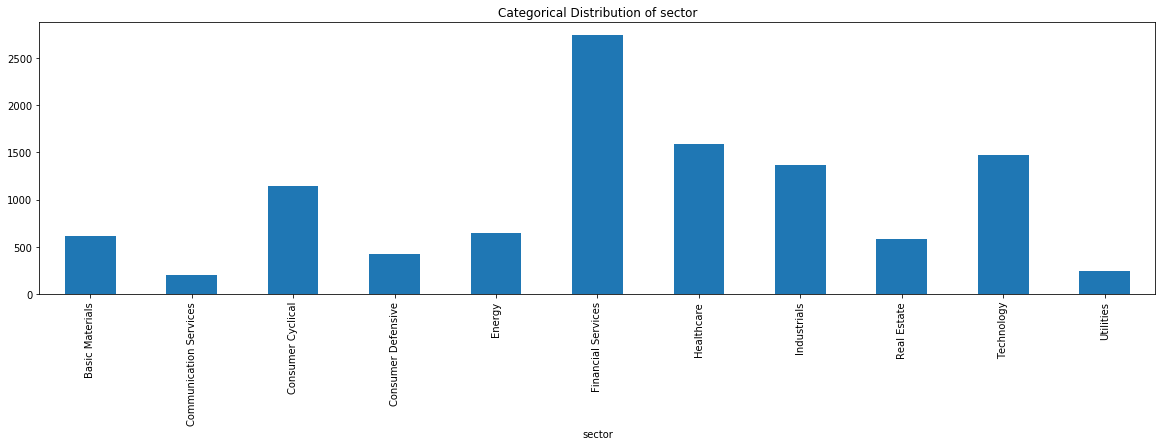

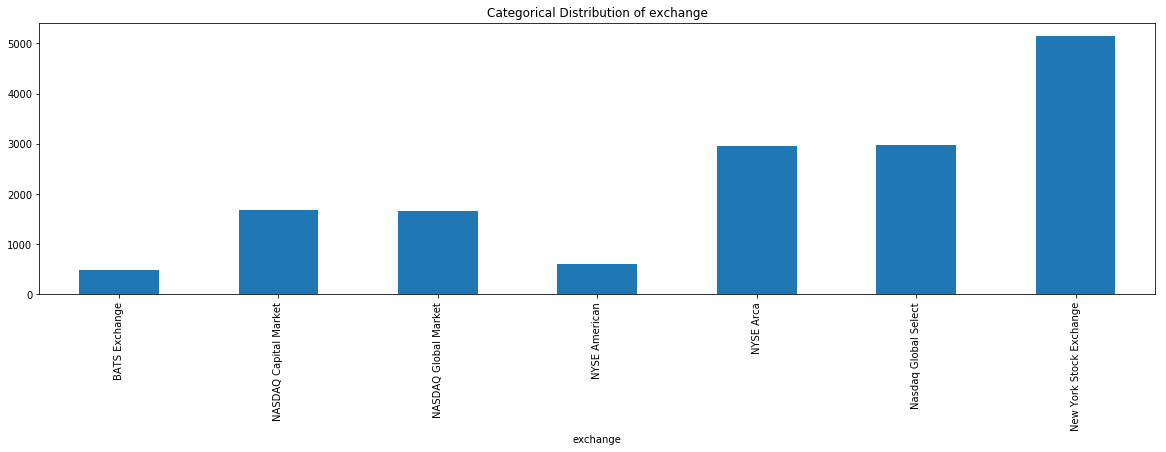

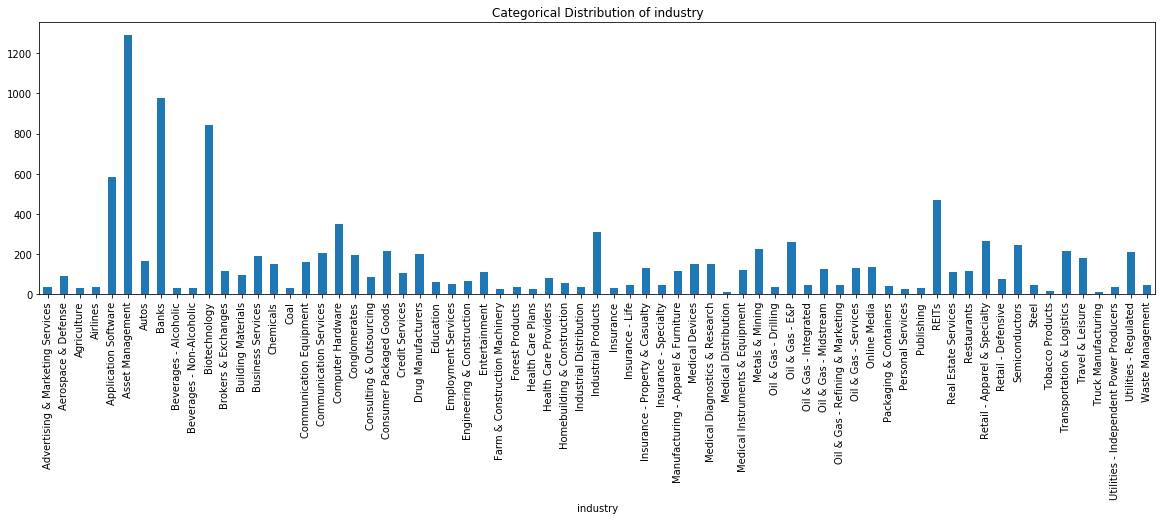

In [5]:
for col in ['sector', 'exchange', 'industry']:
    df_profile.groupby(col).count()['price'].plot.bar(figsize=(20, 5), title='Categorical Distribution of {}'.format(col));
    plt.show()

Now lets use the company description to extract additional features:

In [6]:
# NP extraction
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import RegexpParser
from nltk import Tree

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('omw')

def extract_nouns(text, singular=True):
    '''Retrieves the noun phrases from the given column
    
    Args:
        text (str): Text to extract nouns from
    
    Returns:
        DataFrame only with the extracted column
    '''
    # safty: check correct type
    if not isinstance(text, str):
        #print('error ({}) - ({})'.format(type(text), text))
        return []
    
    # chunk the data
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree:
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk or singular == False:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk

df_profile['description'].head(10).apply(extract_nouns)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-

0                                         [Portfolio]
1    [Comcast Corp, Comcast Cable, NBCUniversal, NBC]
2                   [Kinder Morgan Inc, Company, CO2]
3                                        [Intel Corp]
4    [Micron Technology Inc, DRAM, NAND, NOR, XPoint]
5                       [NYSE Arca Gold Miners Index]
6                                       [Electric Co]
7                         [Bank, America Corporation]
8                  [MSCI Emerging Markets Index, BFA]
9                                  [Financial Select]
Name: description, dtype: object

In [7]:
# Set-Vectorize the noun phrases for each document
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=lambda x: extract_nouns(x), binary=True, lowercase=False)
vecs = cv.fit_transform(df_profile['description'].fillna("").values)
vecs = pd.DataFrame(vecs.toarray())

# merge with original dataframe
df_vecs = pd.concat([df_profile[['symbol', 'sector', 'industry', 'exchange']], vecs], axis=1)
df_vecs.head()

,symbol,sector,industry,exchange,0,1,2,3,4,5,...,9614,9615,9616,9617,9618,9619,9620,9621,9622,9623
0,SPY,NaN,NaN,NYSE Arca,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CMCSA,Consumer Cyclical,Entertainment,Nasdaq Global Select,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,KMI,Energy,Oil & Gas - Midstream,New York Stock Exchange,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,INTC,Technology,Semiconductors,Nasdaq Global Select,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MU,Technology,Semiconductors,Nasdaq Global Select,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


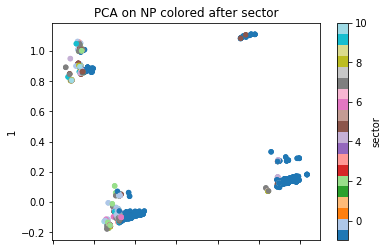

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# perform dimensionality reduction on vectors
def calc_pca(vecs):
    pca = PCA(n_components=2)
    vecs_pca = pca.fit_transform(vecs)
    vecs_pca = pd.DataFrame(vecs_pca)

    # combine data
    df_vecs = pd.concat([df_profile[['symbol', 'sector', 'industry', 'exchange']], vecs_pca], axis=1)
    color = 'sector'
    df_vecs[color] = df_vecs[color].astype("category").cat.codes

    # scatter plot data
    df_vecs.plot.scatter(0, 1, c=color, cmap='tab20', title='PCA on NP colored after sector');

calc_pca(vecs)

What we can learn from this graph, is that the clusters (i.e. the noun-phrases) are apparently not directly correlated with sectors (or exchange or industry if you borther to make the test). However, the clusters are pretty meaningless, as we only created binary vectors, which are bound to split into four clusters in 2D.

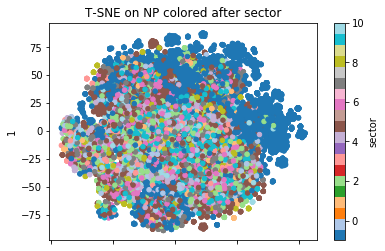

In [9]:
# perform dimensionality reduction on vectors
def calc_tsne(vecs):
    tsne = TSNE(n_components=2)
    vecs_tsne = tsne.fit_transform(vecs)
    vecs_tsne = pd.DataFrame(vecs_tsne)

    # combine data
    df_vecs = pd.concat([df_profile[['symbol', 'sector', 'industry', 'exchange']], vecs_tsne], axis=1)
    color = 'sector'
    df_vecs[color] = df_vecs[color].astype("category").cat.codes

    # scatter plot data
    df_vecs.plot.scatter(0, 1, c=color, cmap='tab20', title='T-SNE on NP colored after sector');

calc_tsne(vecs)

To garther more meaning from the `description` we will use GloVe Embeddings along with T-SNE to identify relevant semantic clusters.

In [ ]:
import sklearn_recommender as rec

# optional: download package
rec.glove.download('twitter')

# create recommender
gt = rec.glove.GloVeTransformer('twitter', 25, 'sent', tokenizer=rec.nlp.tokenize_clean)
embs = gt.transform(df_profile['description'])
embs = pd.DataFrame(embs)

embs.head()

In [ ]:
calc_pca(embs)

In [ ]:
calc_tsne(embs)

Now that we have a basic understanding of the data lets create the actual similarity data, that is relevant to the system

In [ ]:
# create dummy from all values
df_sector_dummy = pd.get_dummies(df_profile['sector'], dummy_na=True, prefix='sector')
df_industry_dummy = pd.get_dummies(df_profile['industry'], dummy_na=True, prefix='industry')
df_exchange_dummy = pd.get_dummies(df_profile['exchange'], dummy_na=True, prefix='exchange')

# combine into final matrix
df_final = pd.concat([df_profile[['symbol']], df_sector_dummy, df_industry_dummy, df_exchange_dummy, embs], axis=1).set_index('symbol')

# calculate confusion matrix (based on different factors)


# calculate confusion matrix

TODO: discuss results